<a href="https://colab.research.google.com/github/bencekovacs01/2D_maze_game/blob/master/pkp_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labor 2

Mint eddig láttuk, a CUDA (Compute Unified Device Architecture) egy párhuzamos számítási platform és heterogén programozási modell. A heterogén számítástechnika olyan rendszerekre vonatkozik, amelyek több fajta számítási eszközt, processzort használnak. Ezek esetében a teljesítménynövekedést nem csak az azonos típusú processzorok hozzáadásával érhetjük el, hanem eltérő processzorok használatával is, amelyek általában speciális feldolgozási képességekkel rendelkeznek, bizonyos típusú feladatok hatékony és eredményes kezelésére. Például a grafikus feldolgozó egységek és a CUDA adatpárhuzamos (az egyes processzorokon futó programok ebben az esetben azonosak, csak az általuk feldolgozott adatok különböznek) feladatok megoldására alkalmas igazán.

A CUDA lehetővé teszi a programjaink számára, hogy bizonyos típusú grafikus feldolgozó egységeket (GPU) használjanak általános célú számításokhoz, feldolgozáshoz, közvetlen hozzáférést biztosítva a GPU virtuális utasításkészletéhez és párhuzamos számítási elemeihez a számítási kernelek végrehajtásához.

A kernel, vagy GPU kód párhuzamosan több szálon futtatott programrészt jelent. Mivel a GPU egy különálló rendszer, saját memóriával, egy tipikus CUDA program a következő lépéseken kell végig haladjon:

*	Memória lefoglalása az eszközön ([`cudaMalloc`](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html#group__CUDART__MEMORY_1g37d37965bfb4803b6d4e59ff26856356))
*	Gazda memóriából másolás az eszközre ([`cudaMemcpy`](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html#group__CUDART__MEMORY_1gc263dbe6574220cc776b45438fc351e8), `cudaMemcpyKind kind = cudaMemcpyHostToDevice`)
*	Szálblokk és a kernel rács méreteinek meghatározása
	```cpp
	dim3 blocks( nx, ny, nz );          
	dim3 threadsPerBlock( mx, my, mz )
	```


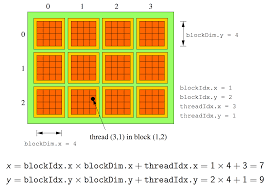


Ábra 1. Szálak hierarchikus szervezése. [Forrás](https://www.ce.jhu.edu/dalrymple/classes/602/Class10.pdf)


*	A CUDA kernel meghívása (`kernel<<<blocks, threadsPerBlock>>>(...)`)
*	Eredmények másolása az eszközről a gazdagép memóriájába ([`cudaMemcpy`](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html#group__CUDART__MEMORY_1gc263dbe6574220cc776b45438fc351e8), `cudaMemcpyKind kind = cudaMemcpyDeviceToHost`)
*	Memória felszabadítása a GPU-n ([`cudaFree`](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html#group__CUDART__MEMORY_1ga042655cbbf3408f01061652a075e094))



## Példa

Két tömb átlagának kiszámítása.

```cpp
#include <cuda.h>
#include <stdio.h>

#define N  1024

__global__ void mKernel(float* a, float* b, float* c){
    int tid = blockIdx.x*blockDim.x + threadIdx.x;

    if(tid < N){
        c[tid] = 0.5*(a[tid] + b[tid]);
        // printf("%d %f\n",tid, c[tid]);
    }

}

int main(int argc, char** argv){
    int i;

    float a[N];
    float b[N];
    float c[N];

    float* dev_a;
    float* dev_b;
    float* dev_c;

    // Memória lefoglalása az eszközön
    cudaMalloc((void**)&dev_a, N * sizeof(float));
    cudaMalloc((void**)&dev_b, N * sizeof(float));
    cudaMalloc((void**)&dev_c, N * sizeof(float));

    for(i=0; i<N; i++){
        a[i] = -i/4.0;
        b[i] = i/6.0;
    }

    // Gazda memóriából másolás az eszközre
    cudaMemcpy(dev_a, a, N*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_b, b, N*sizeof(float), cudaMemcpyHostToDevice);

    // Szálblokk és a kernel rács méreteinek meghatározása
    dim3 blocks((N-1)/256+1, 1, 1);          
    dim3 threadsPerBlock(256, 1, 1);

    // A CUDA kernel meghívása
    mKernel<<<blocks, threadsPerBlock>>>(dev_a, dev_b, dev_c);

    // Eredmények másolása az eszközről a gazdagép memóriájába
    cudaMemcpy(c, dev_c, N*sizeof(float), cudaMemcpyDeviceToHost);

    // Memória felszabadítása a GPU-n
    cudaFree(dev_a);
    cudaFree(dev_b);
    cudaFree(dev_c);
    
    // Eredmény kiíratása  
    for(i=0; i<N; i++){
         printf("(%f + %f)/2 = %f\n", a[i], b[i], c[i]);
    }

    return 0;
}

```

# Képek olvasása

Az ingyenes [CImg Library](https://cimg.eu) egy egyszerű, könnyen használható C++ könyvtár, amely lehetővé teszi a képek manipulálását, feldolgozását és megjelenítését. A könyvtár könnyen telepíthető és használható a fejlesztők számára, és számos képfeldolgozási feladatot meg lehet vele oldani.

Példa kód a CImg Library használatára, kép beolvasására majd kiírására:

```cpp
#include <iostream>
#include "CImg.h"

using namespace cimg_library;

int main() {
  CImg<unsigned char> image("example.jpg"); // kép betöltése
  image.blur(2.5); // elmosás
  image.save("blurred.jpg"); // elmosott kép mentése

  return 0;
}
```


A telepítéshez a Google Colab környezetben, használjuk a köcetkező parancsot:

In [1]:
!apt-get install cimg-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxrandr-dev
Suggested packages:
  xmedcon lapack3-dev cimg-doc cimg-examples libgraphicsmagick++1-dev | libmagick++-dev
  libfftw3-dev | fftw3-dev libgimp2.0-dev libhighgui-dev libtiff5-dev
The following NEW packages will be installed:
  cimg-dev libxrandr-dev
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 554 kB of archives.
After this operation, 5,537 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxrandr-dev amd64 2:1.5.2-1build1 [26.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 cimg-dev all 2.9.4+dfsg-3 [527 kB]
Fetched 554 kB in 0s (1,603 kB/s)
Selecting previously unselected package libxrandr-dev:amd64.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../libxrandr-dev_2%3a1.5.2-1build

A [wget](https://www.gnu.org/software/wget/) parancs segítségével töltsünk le egy képet, melyet majd fel fogunk dolgozni:

In [2]:
!wget --no-check-certificate -O image.jpg https://images.unsplash.com/photo-1570641963303-92ce4845ed4c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=987&q=80

--2024-03-05 16:48:45--  https://images.unsplash.com/photo-1570641963303-92ce4845ed4c?ixlib=rb-4.0.3
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4675983 (4.5M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   4.46M  --.-KB/s    in 0.08s   

2024-03-05 16:48:45 (58.1 MB/s) - ‘image.jpg’ saved [4675983/4675983]



A `CImg` osztály `data()` metódusa lehetővé teszi a képpixelekhez való közvetlen hozzáférést. A `data()` metódus egy pointert térit vissza, amely az első pixelre mutat.  Az adatok típusa az unsigned char tömb, és a képpontok sorfolytonosan, színkanálisónként íródnak. Tehát, nem átlapoltan `RGBRGBRGB...` formában, hanem előszőr a pixelek vörös intenzitása, majd a zöld aztán a kék: `RRRR...GGGG...BBBB`.

Az alábbi példa bemutatja, hogy a `data()` metódus használatával, hogyan tudjuk a képontokat direkt módon elérni, és egy képet szürkeárnyalatuvá alakítani:

In [3]:
%%writefile grayscale.cu
#define cimg_use_jpeg
#include "CImg.h"
#include <iostream>

using namespace cimg_library;
using namespace std;

void grayscale_cpu(unsigned char *r, unsigned char *g, unsigned char *b, unsigned char *grayimg, int width, int height, float wR, float wG){
    for (int row = 0; row < height; row++)
      for (int col = 0; col < width; col++) {
        int offset = row*width + col;
        unsigned val = wR*r[offset] + wG*g[offset] + (1-wR-wG)*b[offset];
        grayimg[offset] = val;
      }
}

int main() {
  CImg<unsigned char> src("./image.jpg");

  int width = src.width();
  int height = src.height();
  cout << width << "x" << height << endl;

  unsigned char *r = src.data();
  unsigned char *g = r + width*height;
  unsigned char *b = g + width*height;;

  int numberOfColorChannels = 1;
  CImg<unsigned char> dest(width, height, 1, numberOfColorChannels);

  unsigned char * gray = dest.data();

  grayscale_cpu(r,g,b,gray,width,height,0.3f,0.59f);
  cout  << "Saving grayscale output\n";
  //dest.save_jpeg("./grayscale.jpg", 100);
  dest.save_pnm("result.pgm");

  return 0;
}

Writing grayscale.cu


Kompilálás:

In [4]:
!nvcc grayscale.cu -lpthread -lX11 -ljpeg

Futtatás:

In [5]:
!./a.out

4000x6000
Saving grayscale output


In [6]:
!ls

a.out  grayscale.cu  image.jpg	result.pgm  sample_data


GPU teszt:

In [7]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Feladatok

1. Futtassuk és ellemezük az fenti átlagszámolás példát.
	* Hány globális memóriaolvasást hajt végre a kernel?
	* Mi az a maximális vektor méret amire még lefut a program?
	* Mit kell változtassunk a program szerkezetén, hogy akár több gigabájt memóriát is sikerüljön lefoglalni?

2. Írjunk egy CUDA programot mely kiszámolja két `N x N` négyzetes mátrix mellékátlóra szimmetrikus összegét:

	`C(x, y) = A(x, y) + B(N-x, N-y)`

	Pl.

	```
       _      _
      |11 13 15|
    A =|17 19 21|
      |23 25 27|
      -      -

        _      _
       |64 60 56|
    B =|52 48 44|
       |40 36 32|
       -      -

         _              _
        |11+32 13+36 15+40|
    C = |17+44 19+48 21+52|
        |23+56 25+60 27+64|
         -               -
	```




  Próbáljuk ki az egydimenziós és kétdimenziós rács és blokkszervezést is. Melyik esetben könnyebb megírni a kernelt?

3. A fentebb található példából kiindulva, írjunk egy CUDA programot, mely a GPU-n végzi el egy kép pixeleinek szürkeárnyalatú transzformálásának a műveleteit.
  
  Lépések:

  * memória lefoglalás az eszközön.
  * kép másolása az eszközre.
  * szálblokk és rács méreteinek, konfigurációjának a meghatározása.
  * CUDA kernel meghívása.
  * az eredmény másolása az eszközről a gazdagépre (host).
  memória felszabadítása az eszközön

# Válaszok

1.
*   A kernel 2*N darab globális memóriaolvasást végez, amikor az `a[stride]` és `b[stride]` értékeket olvassa. A mi esetünkben a vektorok hozza 1024, tehát `2 * 1024 = 2048` olvasás történik.
*   A maximális vektor mérete, amelyre lefut a program többszöri próbálkozás után `2^19*sizeof(float)`, amely `524288 * 4 = 2097152` bájt. `2^20`-ra már nem fut le a megadott program.
*   Annak érdekében, hogy több gigabájt memóriát le tudjon az algoritmus foglalni, ahhoz első sorban szükséges, hogy az `a`, `b` és `b` tömbök ne statikusan, hanem dinamikusan legyenek lefoglalva. Ezáltal azok nem a `stack`-en, hanem a `heap`-ben lesznek tárolva. A `heap`-en nagyságrendileg több helyet lehet lefoglalni a memóriában. Számszerűleg az `1 GB = 1024 * 1024 = 1,048,576 B`, ezt el kell osztani a vektorok száma és a `float` méretének szorzatával, ami `1,048,576 / 12 = 87,381.33`. `2^17 = 131072` a 2 első olyan hatványa, ami meghaladja a kapott értéket. Ezáltal `N = 2^17` elegendő ahhoz, hogy legalább 1 GB memóriát lefoglaljunk.

2.
